# <span style="color:green"> Numerical Simulation Laboratory (NSL) </span>
## <span style="color:blue">  Numerical exercises 4</span>

### Exercise 04.1

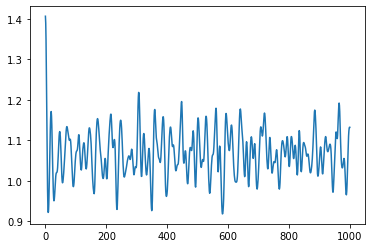

In [10]:
import numpy as np
import matplotlib.pyplot as plt

temperature = np.loadtxt("MolecularDynamics_NVE/output_temp.dat")
temperature_test = np.loadtxt("MolecularDynamics_NVE/output_temp_test.dat")

plt.plot(temperature)
#plt.plot(temperature_test)

### Exercise 04.2

### Exercise 04.3

### <span style="color:green"> Optional exercise</span>